In [199]:
import math as ma
import yfinance as yf
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler 
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Activation, Input, concatenate
import datetime as dt
import matplotlib.pyplot as plt 
import pandas_ta as ta
import tensorflow as tf

from keras import optimizers
from keras.callbacks import History

np.set_printoptions(formatter={'float': lambda x: "{0:0.7f}".format(x)})

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

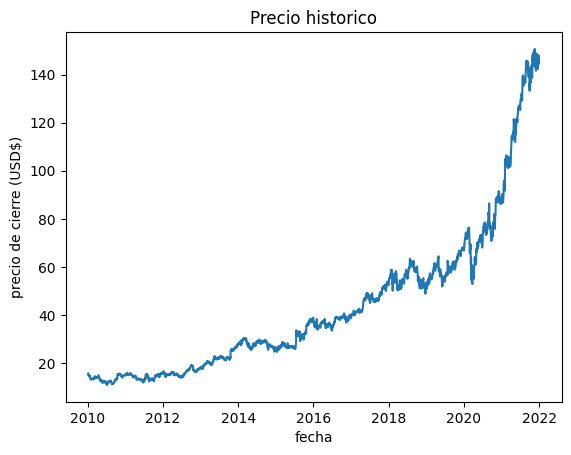

(328, 5)


In [200]:
#var de testeo
stride = 30
simbolo = "Goog"
#conseguir la data
#dfTrain = web.DataReader('SYP', 'stooq', dt.datetime(2020,1,1), dt.datetime(2023,1,1))
dfTrain = yf.download(tickers= simbolo, start= dt.datetime(2010,1,1), end= dt.datetime(2022,1,1))
dfTest =  yf.download(simbolo, start = dt.datetime(2022,1,1),end = dt.date.today()) #dt.date.today())

dataTrain = dfTrain.filter(['Close'])
grafData = dataTrain.copy()
#agrego indicadores: 
dataTrain['RSI']=ta.rsi(dataTrain['Close'], length=15)
dataTrain['EMAF']=ta.ema(dataTrain['Close'], length=20)
dataTrain['EMAM']=ta.ema(dataTrain['Close'], length=100)
dataTrain['EMAS']=ta.ema(dataTrain['Close'], length=150)
dataTrain.dropna(inplace=True)
#dataTrain.reset_index(inplace = True)
#agrego indicadores para test: 
dataTest = dfTest.filter(['Close'])

dataTest['RSI']=ta.rsi(dataTest['Close'], length=15)
dataTest['EMAF']=ta.ema(dataTest['Close'], length=20)
dataTest['EMAM']=ta.ema(dataTest['Close'], length=100)
dataTest['EMAS']=ta.ema(dataTest['Close'], length=150)

dataTestAux = dataTest['Close'][:149]
dataTest.dropna(inplace=True)




plt.title('Precio historico')
plt.plot(grafData)
plt.xlabel("fecha")
plt.ylabel("precio de cierre (USD$)")
# plt.axis((2020,2023,ma.floor(min(dataTrain.values)), ma.ceil(max(dataTrain.values))))
plt.show()


# print((dataTrain['Close'][0] - min(dataTrain['Close']))/(max(dataTrain['Close'])-min(dataTrain['Close'])))
# print(dataTrain)

dataTrain =dataTrain.values 
dataTest = dataTest.values


# dataTrain = np.flip(dataTrain)
# dataTest = np.flip(dataTest)

print((dataTest.shape))


In [201]:
#normalizar la data 
scaler = MinMaxScaler(feature_range=(0,1))
dataNormTrain = scaler.fit_transform(dataTrain)
dataNormTest = scaler.fit_transform(dataTest)
print(dfTest['Close'][-10:])

# print(dataNormTrain[0:stride+1,:])
# print(dataNormTrain[stride,:])
# print(dataNormTrain)
print(dataTest[-10:,0])
print(dataNormTest[-10:,0])

# print(dataNormTest[0:stride+1,:])
# print(dataNormTest[stride,:])

Date
2023-11-10    134.059998
2023-11-13    133.639999
2023-11-14    135.429993
2023-11-15    136.380005
2023-11-16    138.699997
2023-11-17    136.940002
2023-11-20    137.919998
2023-11-21    138.619995
2023-11-22    140.020004
2023-11-24    138.220001
Name: Close, dtype: float64
[134.0599976 133.6399994 135.4299927 136.3800049 138.6999969 136.9400024
 137.9199982 138.6199951 140.0200043 138.2200012]
[0.8687511 0.8615359 0.8922865 0.9086069 0.9484625 0.9182272 0.9350627
 0.9470881 0.9711391 0.9402165]


In [202]:
#crear el dataset de entrenamiento 
#separar entre X e Y dataSets
#X son las entradas e Y es la salida esperada
x_train = []
y_train = []


for i in range(stride, len(dataNormTrain)):
    x_train.append(dataNormTrain[i-stride:i, :])
    y_train.append(dataNormTrain[i,0])
    # if i<=stride:
    #     print(x_train)
    #     print(y_train)

#print(x_train[3], y_train[:3])

# for i in range(len(x_train)):
#     print(x_train[i], y_train[i]) 

#yi = np.array(dataNormTrain[stride:,-1])
#y=np.reshape(yi,(len(yi),1))

# for i in range(stride,len(dataNormTrain)):
#     x_train.append(dataNormTrain[i-stride:i,0])
#     y_train.append(dataNormTrain[i,0])




In [203]:
#hacerlos np.arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
#el modelo necesita el numero de samples, de datos y de features

In [204]:
#construir la red LSTM #!aprender que hace esto bien (o buscar el codigo pelado)

lstm_input = Input(shape=(stride, x_train.shape[2]), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
#inputs = LSTM(50, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=x_train, y=y_train, epochs=50, batch_size=stride, shuffle=True, validation_split = 0.1) 

Epoch 1/50
86/86 [==============================] - 4s 24ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 2/50
86/86 [==============================] - 2s 18ms/step - loss: 1.0038e-04 - val_loss: 0.0024
Epoch 3/50
86/86 [==============================] - 2s 19ms/step - loss: 8.0623e-05 - val_loss: 0.0014
Epoch 4/50
86/86 [==============================] - 2s 18ms/step - loss: 7.5733e-05 - val_loss: 0.0015
Epoch 5/50
86/86 [==============================] - 2s 19ms/step - loss: 7.9496e-05 - val_loss: 0.0011
Epoch 6/50
86/86 [==============================] - 2s 19ms/step - loss: 6.1690e-05 - val_loss: 0.0013
Epoch 7/50
86/86 [==============================] - 2s 19ms/step - loss: 6.3360e-05 - val_loss: 4.0841e-04
Epoch 8/50
86/86 [==============================] - 2s 18ms/step - loss: 5.7809e-05 - val_loss: 3.7917e-04
Epoch 9/50
86/86 [==============================] - 2s 18ms/step - loss: 6.4073e-05 - val_loss: 3.0258e-04
Epoch 10/50
86/86 [==============================] - 2s 18ms/step

In [224]:
#crea datos para test
#separa en X y en Y 

testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
#!no esta bien pq se saltea los que borre de test
#print(testData)
x_test = []
y_test = dataTest[:,0]

# print(len(dataTest))

for i in range(stride, len(testData)):
     x_test.append(testData[i-stride:i,:])
#X contiene los valores no contempleados en el train, e y contiene la salida esperada
x_test = np.array(x_test)

#x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2]))
#print(x_test[1])
#print(y_test[1])


In [206]:
#print(model.predict(x_test[:-30]))

In [225]:
#prediccion del modelo para test
prediccion = np.zeros((x_test.shape[0],5))
aux = model.predict(x_test)
aux = np.reshape(aux,(aux.shape[0]))
#print(aux)
prediccion[:,0] = aux[:]
prediccion = scaler.inverse_transform(prediccion)
prediccion = prediccion[:,0]
# print(prediccion.shape[0])

11/11 [==============================] - 0s 10ms/step


In [226]:
# print(prediccion[:10])
# print(y_test[:10])

[141.4597489 135.3906340 127.0114339 121.1330179 116.0070163 114.1388592
 113.6104621 113.9947673 114.0617373 115.4346630]
[118.1399994 117.5000000 120.6500015 119.8199997 122.6500015 122.8799973
 122.5100021 120.3199997 120.8600006 118.1200027]


In [227]:
#calcular error del modelo (RMSE)
print(len(prediccion))
rmse = np.sqrt(np.mean((prediccion - y_test)**2))
print("{:.2f}".format(rmse))


328
4.58


In [221]:
# prediccion = np.flip(prediccion)

In [228]:
#Arma las estructuras para  graficar
train = dfTrain
valid = dfTest
prediccion = np.concatenate((dataTestAux[:], prediccion[:]))

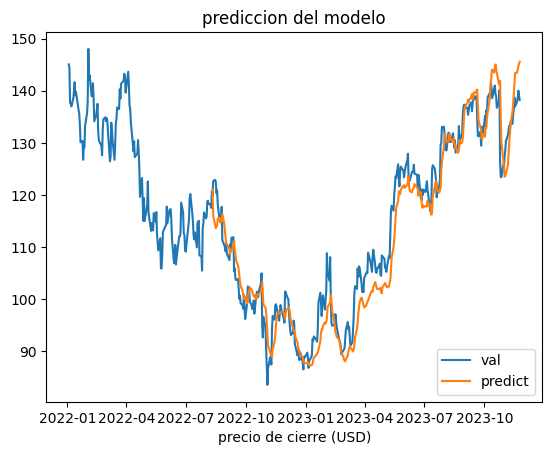

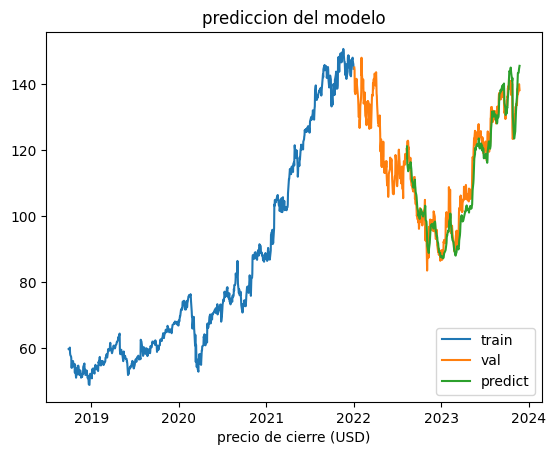

In [242]:

#testData = np.concatenate((dataNormTrain[-stride:,:],dataNormTest)) 
valid['Predictions'] = prediccion

#plot
plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
#plt.plot(train['Close'][2000:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['val', 'predict'], loc = 'lower right')
plt.figure()


plt.title("prediccion del modelo")
plt.xlabel("modelo")
plt.xlabel("precio de cierre (USD)")
plt.plot(train['Close'][2200:])
plt.plot(valid['Close']) 
plt.plot(valid['Predictions'][152:])
plt.legend(['train', 'val', 'predict'], loc = 'lower right')
plt.show()


In [213]:
#imprimir los valores
print(valid[['Close', 'Predictions']][149:])

                 Close  Predictions
Date                               
2022-08-08  118.139999   141.459749
2022-08-09  117.500000   135.390634
2022-08-10  120.650002   127.011434
2022-08-11  119.820000   121.133018
2022-08-12  122.650002   116.007016
...                ...          ...
2023-11-17  136.940002   143.391781
2023-11-20  137.919998   143.459313
2023-11-21  138.619995   144.126050
2023-11-22  140.020004   144.722485
2023-11-24  138.220001   145.576975

[328 rows x 2 columns]


In [264]:
#simulacion de trading 
dineroInicial = 100
#print(dataNormTest[:,0])

dataTestSemana = dataNormTest[-(5 + stride):,:]
dataTestMes = dataNormTest[-(20 + stride):,:]
dataTestAnual = dataNormTest[-(287 + stride):,:]

testCase = dataTestSemana
#print(len(dataTestSemana))
# print(dataTestMes)
# print(dataTestAnual)
x_test = []
predic = np.zeros((dataTestSemana.shape[0]-stride,5))

for i in range(stride, len(testCase)):
    x_test.append(testCase[i-stride:i,:])
x_test = np.array(x_test)

aux = model.predict(x_test)
aux = np.reshape(aux,(aux.shape[0]))
predic[:,0] = aux[:]


testCase = scaler.inverse_transform(testCase)
predic = scaler.inverse_transform(predic)

predic = predic[:,0]
testCase = testCase[:,0]

#simulacion:
dineroTot = dineroInicial
for i in range(len(predic)): 
    if (predic[i]>=testCase[stride + i - 1]): #si mañana va a subir, holdeo 
        
    else: #va a bajar, conviene vender


print(testCase)
print(predic)


1/1 [==============================] - 0s 29ms/step
[138.7299957 139.5000000 139.1999969 141.6999969 140.2899933 138.5800018
 140.4900055 140.9900055 139.2799988 138.9799957 136.7400055 137.8999939
 140.1199951 126.6699982 123.4400024 123.4000015 125.7500000 125.3000031
 127.5699997 128.5800018 130.3699951 131.4499969 132.3999939 133.2599945
 131.6900024 134.0599976 133.6399994 135.4299927 136.3800049 138.6999969
 136.9400024 137.9199982 138.6199951 140.0200043 138.2200012]
[143.3917811 143.4593131 144.1260497 144.7224924 145.5769752]
